In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
horizon = 25
alpha = 0.42
env = gym.make("cpr_gym_rs:Nakamoto-v0", alpha=alpha, horizon=horizon)

In [3]:
def do_nothing_policy(o):
    return env.unwrapped.encode_action_continue()


def selfish_mining_policy(o):
    assert o.shape == (3,)
    a = o[0]
    h = o[1]
    if h > a:
        return env.unwrapped.encode_action_consider(0)  # adopt
    if a == 1 and h == 1:
        return env.unwrapped.encode_action_release(0)  # match
    if h == a - 1 and h >= 1:
        return env.unwrapped.encode_action_release(0)  # override
    return env.unwrapped.encode_action_continue()  # continue / wait


_ = env.reset()
_, _, _, _, info = env.step(env.unwrapped.encode_action_continue())
keys = sorted(info.keys())


def simulate(policy, label):
    episodes = []

    def ep_dict():
        d = dict(steps=0)
        for k in keys:
            d[k] = 0
        return d

    def acc_dict(d, info):
        d["steps"] += 1
        for k in keys:
            d[k] += info[k]

    ep = ep_dict()
    obs, info = env.reset()
    for i in range(50000):
        a = policy(obs)
        obs, r, term, trunc, info = env.step(a)
        acc_dict(ep, info)
        if term or trunc:
            episodes.append(dict(policy=label) | ep)
            ep = ep_dict()
            obs, info = env.reset()

    return episodes


episodes = pd.DataFrame(
    simulate(do_nothing_policy, "do-nothing")
    + simulate(selfish_mining_policy, "selfish-mining")
)
episodes

,policy,steps,progress,reward_attacker,reward_defender,rewrite,time
0,do-nothing,70,43.0,0.0,43.0,0,70
1,do-nothing,19,10.0,0.0,10.0,0,19
2,do-nothing,4,3.0,0.0,3.0,0,4
3,do-nothing,12,6.0,0.0,6.0,0,12
4,do-nothing,101,60.0,0.0,60.0,0,101
...,...,...,...,...,...,...,...
1820,selfish-mining,24,10.0,8.0,2.0,2,15
1821,selfish-mining,161,53.0,39.0,14.0,12,81
1822,selfish-mining,26,11.0,6.0,5.0,1,15
1823,selfish-mining,51,20.0,8.0,12.0,3,26


In [4]:
horizon, episodes.progress.mean()

(25, 26.18849315068493)

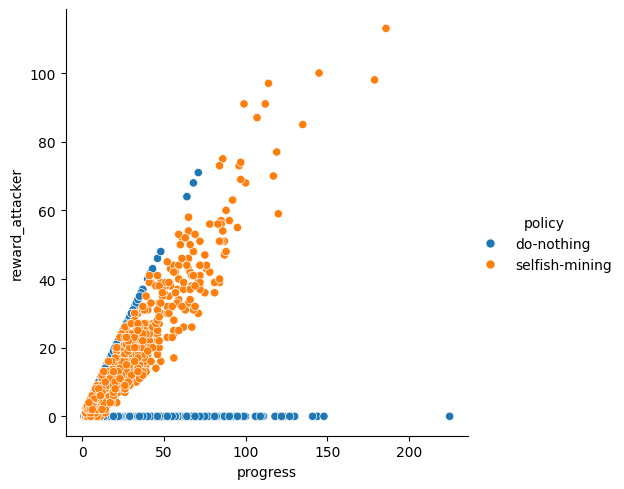

In [5]:
sns.relplot(data=episodes, x="progress", y="reward_attacker", hue="policy")

In [6]:
for policy in episodes.policy.unique():
    subset = episodes.query(f"policy == '{policy}'")
    print(policy, alpha, (subset.reward_attacker / subset.progress).mean())

do-nothing 0.42 0.1298366294067068
selfish-mining 0.42 0.5646802627569943
